## My autoencoder PyTorch
Dimensionality reduction: Compress gigapixel slides or patches into lower-dimensional feature embeddings.
#### Types of autoencoder
- Convolutional Autoencoders (CNN-AE)
- Variational Autoencoders (VAEs)
- Denoising Autoencoders (DAEs)
- Sparse Autoencoders
- Stacked/Hierarchical Autoencoders
- Contrastive Autoencoders (Hybrid with Self-Supervision)

### Convolutional Autoencoders (CNN-AE)
- **Encoder**: series of Conv2D + pooling layers → compress image patches
- **Latent space**: compact feature vector (100s–1000s dimensions)
- **Decoder**: Conv2DTranspose or upsampling → reconstruct image
- Best for: learning morphological features (cell nuclei, gland structures)
- Steps:
	1.	Patch extraction from WSIs (e.g., 224×224)
	2.	Normalize patches (stain normalization)
	3.	Train AE to minimize reconstruction loss (MSE, SSIM)
	4.	Use latent vectors for clustering or as input to classifiers

In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [70]:
# DATA - classes

# Preprocessing (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),                 # Must come first!
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # 3-channel normalization to [-1,1]
])

PATCHES_PATH = "/Volumes/tereju_disk/RECETOX/autoencoder/coad/kather01"

# Custom function to filter out macOS system files
def is_valid_file(path):
    # Exclude macOS system files that start with ._
    filename = path.split('/')[-1]
    return not filename.startswith('._') and not filename.startswith('.DS_Store')

# Load dataset with custom filter to exclude system files
dataset = datasets.ImageFolder(root=PATCHES_PATH, transform=transform, is_valid_file=is_valid_file)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=32, shuffle=False)

In [64]:
# Autoencoder Architecture - Class

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [B,32,75,75]
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # [B,64,38,38]
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# [B,128,19,19]
        #     nn.ReLU()
        # )
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 3x150x150 -> 32x75x75
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x38x38
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128x19x19
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # [B,64,38,38]
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B,32,75,75]
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # [B,3,150,150]
        #     nn.Sigmoid()  # keep outputs in [0,1]
        # )
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # normalize outputs to [0,1]
        )        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Autoencoder Architecture - Fixed size matching
# Kernel size considerations: from 3x3 to 4x4
# added output_padding=1 


class CNNAutoencoder_2(nn.Module):
    def __init__(self):
        super(CNNAutoencoder_2, self).__init__()
        
        # Encoder - Carefully calculated for 150x150 input
        self.encoder = nn.Sequential(
            # Layer 1: 150x150x3 -> 75x75x64
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Layer 2: 75x75x64 -> 38x38x128 (75//2 + 75%2 = 38)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Layer 3: 38x38x128 -> 19x19x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # Layer 4: 19x19x256 -> 10x10x512 (19//2 + 19%2 = 10)
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # Decoder - Symmetric upsampling with correct output_padding
        self.decoder = nn.Sequential(
            # Layer 1: 10x10x512 -> 19x19x256
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Layer 2: 19x19x256 -> 38x38x128  
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Layer 3: 38x38x128 -> 75x75x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Layer 4: 75x75x64 -> 150x150x3 (use kernel_size=4 to get exact 150x150)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh()  # Match input normalization [-1,1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # # Handle size mismatch using interpolation instead of adaptive pooling for MPS compatibility
        # if decoded.size(-1) != 150 or decoded.size(-2) != 150:
        #     decoded = F.interpolate(decoded, size=(150, 150), mode='bilinear', align_corners=False)
        return decoded

In [88]:
# Test the architecture dimensions
def test_autoencoder_dimensions():
    model = CNNAutoencoder_2()
    test_input = torch.randn(1, 3, 150, 150)
    
    print(f"Input shape: {test_input.shape}")
    
    # Test full forward pass
    output = model(test_input)
    print(f"Final output shape after full forward pass: {output.shape}")
    
    return output.shape

test_autoencoder_dimensions()

Input shape: torch.Size([1, 3, 150, 150])
Final output shape after full forward pass: torch.Size([1, 3, 150, 150])


torch.Size([1, 3, 150, 150])

In [ ]:
# TRAINING

import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # lowered from 1e-3 after train_3

epochs = 9

for epoch in range(epochs):
    model.train()
    for data in train_loader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Fix size mismatch by resizing outputs to match inputs
        if outputs.shape != inputs.shape:
            outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bilinear', align_corners=False)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.2079407423734665
Epoch 2, Loss: 0.19510482251644135
Epoch 2, Loss: 0.19510482251644135
Epoch 3, Loss: 0.14890937507152557
Epoch 3, Loss: 0.14890937507152557
Epoch 4, Loss: 0.16833336651325226
Epoch 4, Loss: 0.16833336651325226
Epoch 5, Loss: 0.17026963829994202
Epoch 5, Loss: 0.17026963829994202
Epoch 6, Loss: 0.20389829576015472
Epoch 6, Loss: 0.20389829576015472
Epoch 7, Loss: 0.15250995755195618
Epoch 7, Loss: 0.15250995755195618
Epoch 8, Loss: 0.1380414217710495
Epoch 8, Loss: 0.1380414217710495
Epoch 9, Loss: 0.1673833280801773
Epoch 9, Loss: 0.1673833280801773


In [84]:
# TRAINING - improved

# IMPROVED TRAINING
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CNNAutoencoder_2().to(device)

# Combined loss function
def combined_loss(output, target, alpha=0.8):
    mse_loss = F.mse_loss(output, target)
    # Add perceptual loss component
    l1_loss = F.l1_loss(output, target)
    return alpha * mse_loss + (1-alpha) * l1_loss

criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}')
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')

Epoch 1, Batch 0, Loss: 0.514539
Epoch 1, Batch 10, Loss: 0.118314
Epoch 1, Batch 10, Loss: 0.118314
Epoch 1, Batch 20, Loss: 0.096815
Epoch 1, Batch 20, Loss: 0.096815
Epoch 1, Batch 30, Loss: 0.094100
Epoch 1, Batch 30, Loss: 0.094100
Epoch 1, Batch 40, Loss: 0.085693
Epoch 1, Batch 40, Loss: 0.085693
Epoch 1, Batch 50, Loss: 0.074569
Epoch 1, Batch 50, Loss: 0.074569
Epoch 1, Batch 60, Loss: 0.073625
Epoch 1, Batch 60, Loss: 0.073625
Epoch 1, Batch 70, Loss: 0.068058
Epoch 1, Batch 70, Loss: 0.068058
Epoch 1, Batch 80, Loss: 0.074428
Epoch 1, Batch 80, Loss: 0.074428
Epoch 1, Batch 90, Loss: 0.074258
Epoch 1, Batch 90, Loss: 0.074258
Epoch 1, Batch 100, Loss: 0.067495
Epoch 1, Batch 100, Loss: 0.067495
Epoch 1, Batch 110, Loss: 0.072714
Epoch 1, Batch 110, Loss: 0.072714
Epoch 1, Batch 120, Loss: 0.076557
Epoch 1, Batch 120, Loss: 0.076557
Epoch 1: Train Loss: 0.094796, Val Loss: 0.063077
Epoch 1: Train Loss: 0.094796, Val Loss: 0.063077
Epoch 2, Batch 0, Loss: 0.084661
Epoch 2, Bat

KeyboardInterrupt: 

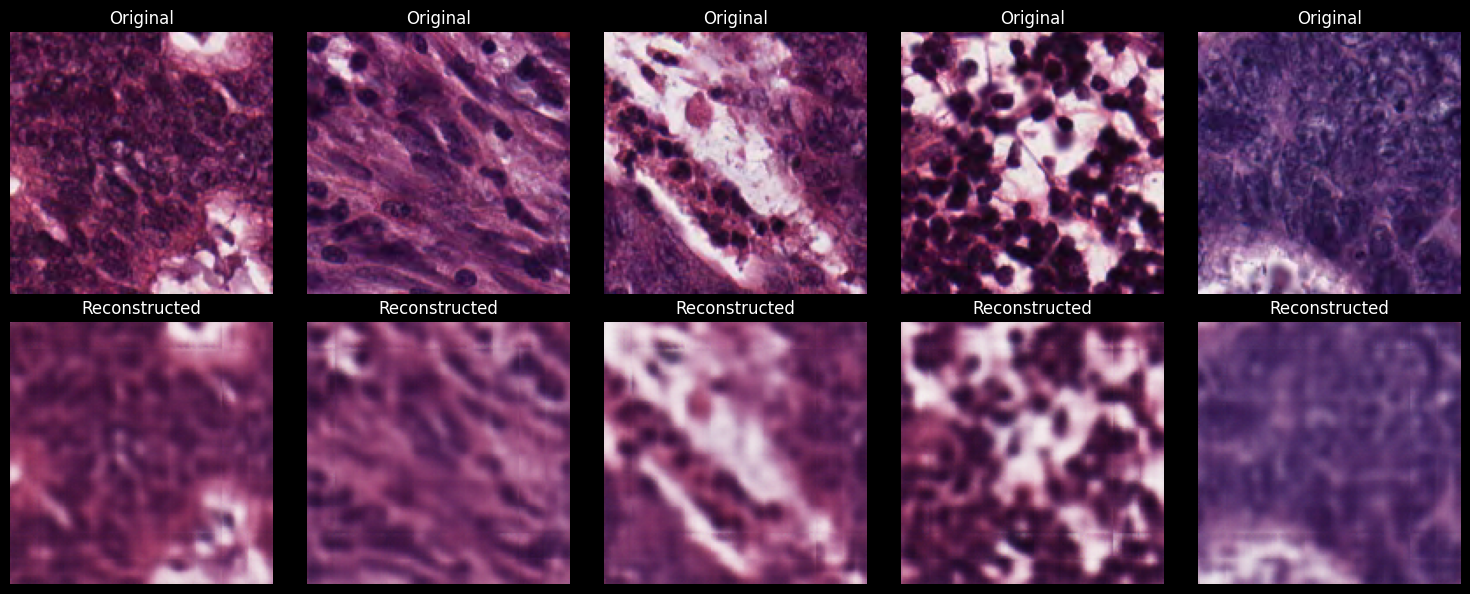

In [85]:
# EVALUATION - show images

def show_reconstructed_images(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs = data[0].to(device)
            outputs = model(inputs)
            
            # Fix size mismatch for visualization too
            if outputs.shape != inputs.shape:
                outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bilinear', align_corners=False)
            
            # Convert tensors for visualization
            # Denormalize: from [-1,1] back to [0,1]
            inputs_vis = (inputs + 1.0) / 2.0
            outputs_vis = torch.clamp((outputs + 1.0) / 2.0, 0, 1)
            
            # Create subplots
            fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
            
            # Show original and reconstructed images
            for j in range(min(num_images, inputs.shape[0])):
                # Original image
                axes[0, j].imshow(inputs_vis[j].cpu().numpy().transpose(1, 2, 0))
                axes[0, j].set_title('Original')
                axes[0, j].axis("off")
                
                # Reconstructed image
                axes[1, j].imshow(outputs_vis[j].cpu().numpy().transpose(1, 2, 0))
                axes[1, j].set_title('Reconstructed')
                axes[1, j].axis("off")
            
            plt.tight_layout()
            plt.show()
            break  # Only show first batch

show_reconstructed_images(model, val_loader, num_images=5)

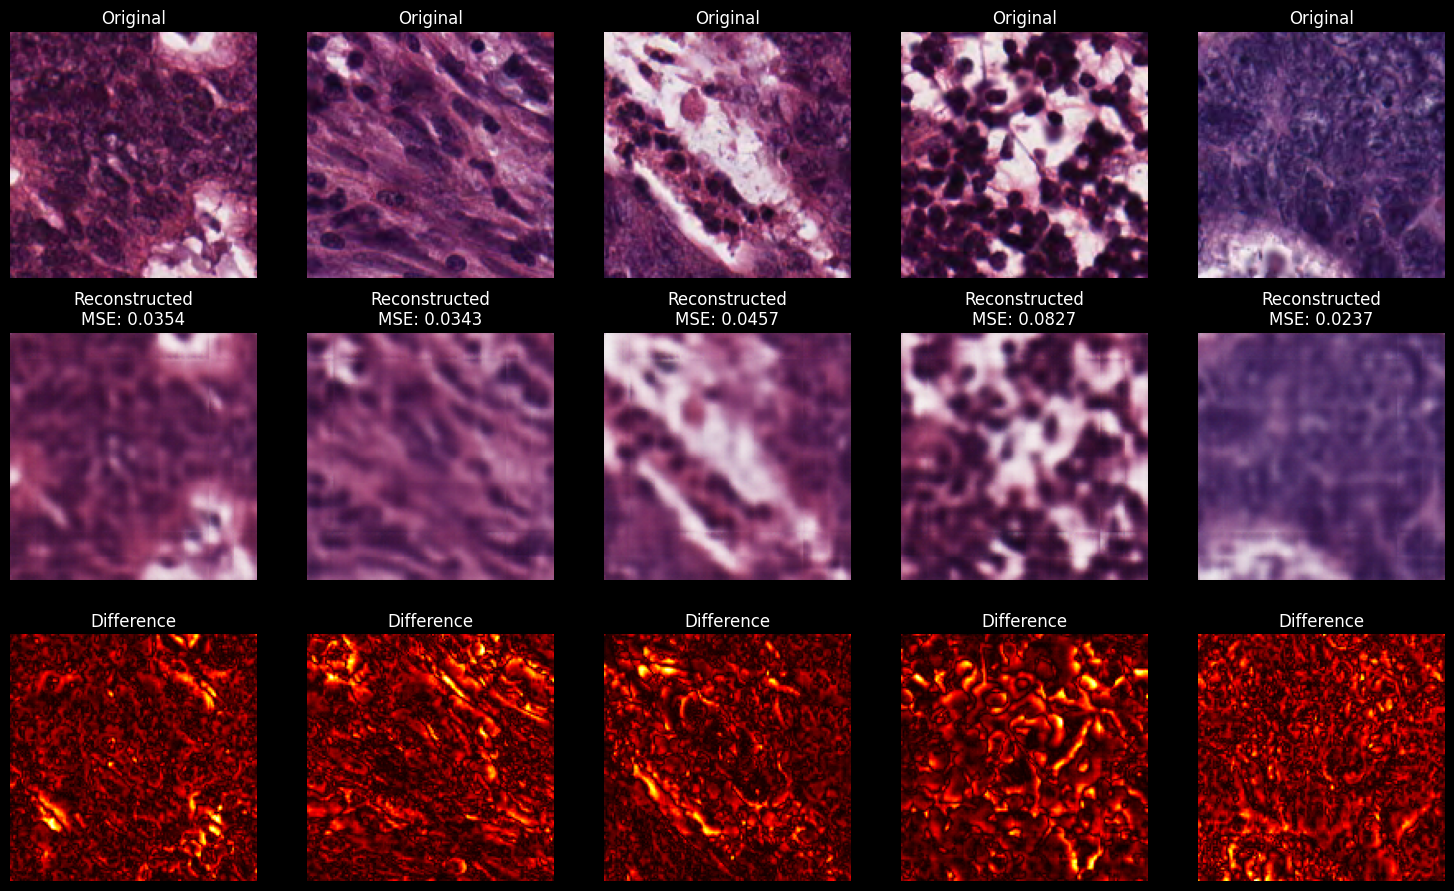

In [86]:
def show_reconstructed_images_improved(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0][:num_images].to(device)
            outputs = model(inputs)
            
            # Proper denormalization from [-1,1] to [0,1]
            inputs_vis = (inputs + 1.0) / 2.0
            outputs_vis = (outputs + 1.0) / 2.0
            
            # Calculate reconstruction error
            mse_per_image = F.mse_loss(outputs, inputs, reduction='none').mean(dim=[1,2,3])
            
            fig, axes = plt.subplots(3, num_images, figsize=(15, 9))
            
            for j in range(num_images):
                # Original
                axes[0, j].imshow(inputs_vis[j].cpu().numpy().transpose(1, 2, 0))
                axes[0, j].set_title('Original')
                axes[0, j].axis('off')
                
                # Reconstructed
                axes[1, j].imshow(torch.clamp(outputs_vis[j], 0, 1).cpu().numpy().transpose(1, 2, 0))
                axes[1, j].set_title(f'Reconstructed\nMSE: {mse_per_image[j]:.4f}')
                axes[1, j].axis('off')
                
                # Difference
                diff = torch.abs(inputs_vis[j] - outputs_vis[j]).mean(dim=0)
                axes[2, j].imshow(diff.cpu().numpy(), cmap='hot')
                axes[2, j].set_title('Difference')
                axes[2, j].axis('off')
            
            plt.tight_layout()
            plt.show()
            break

show_reconstructed_images_improved(model, val_loader)